In [ ]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

In [2]:
# quota_df = pd.read_csv("./data/quota.csv")
# quota_df.head()

In [87]:
price_df = pd.read_pickle("./data/prices.pkl")
price_df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01,1,Category A,1152,1145,1342,18502
1,2010-01,1,Category B,687,679,883,19190
2,2010-01,1,Category C,173,173,265,19001
3,2010-01,1,Category D,373,365,509,889
4,2010-01,1,Category E,586,567,1011,19889


## Feature Engineering

In [4]:
def clean_dtypes(df):
    df = df.copy()

    int_cols = ["quota", "bids_success", "bids_received", "premium"]
    for col in int_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .astype(int)
        )

    # Convert month like "2010-01" → datetime
    df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

    return df

price_df = clean_dtypes(price_df)
price_df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01-01,1,Category A,1152,1145,1342,18502
1,2010-01-01,1,Category B,687,679,883,19190
2,2010-01-01,1,Category C,173,173,265,19001
3,2010-01-01,1,Category D,373,365,509,889
4,2010-01-01,1,Category E,586,567,1011,19889


In [5]:
def add_auction_date(df):
    df = df.copy()

    day_map = df["bidding_no"].map({1: 1, 2: 15})
    df["auction_date"] = df["month"] + pd.to_timedelta(day_map - 1, unit="D")

    df = df.sort_values(["vehicle_class", "auction_date"]).reset_index(drop=True)
    return df

price_df = add_auction_date(price_df)
price_df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,auction_date
0,2010-01-01,1,Category A,1152,1145,1342,18502,2010-01-01
1,2010-01-01,2,Category A,1151,1149,1673,20501,2010-01-15
2,2010-02-01,1,Category A,1154,1153,1326,19989,2010-02-01
3,2010-02-01,2,Category A,1148,1148,1493,20340,2010-02-15
4,2010-03-01,1,Category A,1148,1141,1758,20802,2010-03-01


In [85]:
price_df[price_df["vehicle_class"] == "Category A"]

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,auction_date,oversub,log_premium,log_quota,log_oversub,month_num,moy_sin,moy_cos,log_premium_lag1,log_oversub_lag1
0,2010-01-01,1,Category A,1152,1145,1342,18502,2010-01-01,1.164931,9.825634,7.049255,0.152661,1,5.000000e-01,8.660254e-01,NaN,NaN
1,2010-01-01,2,Category A,1151,1149,1673,20501,2010-01-15,1.453519,9.928229,7.048386,0.373987,1,5.000000e-01,8.660254e-01,9.825634,0.152661
2,2010-02-01,1,Category A,1154,1153,1326,19989,2010-02-01,1.149047,9.902937,7.050989,0.138933,2,8.660254e-01,5.000000e-01,9.928229,0.373987
3,2010-02-01,2,Category A,1148,1148,1493,20340,2010-02-15,1.300523,9.920345,7.045777,0.262766,2,8.660254e-01,5.000000e-01,9.902937,0.138933
4,2010-03-01,1,Category A,1148,1141,1758,20802,2010-03-01,1.531359,9.942804,7.045777,0.426156,3,1.000000e+00,6.123234e-17,9.920345,0.262766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2025-11-01,1,Category A,1306,1303,1682,110002,2025-11-01,1.287902,11.608254,7.174724,0.253015,11,-5.000000e-01,8.660254e-01,11.711776,0.438001
375,2025-11-01,2,Category A,1285,1279,1587,109000,2025-11-15,1.235019,11.599103,7.158514,0.211087,11,-5.000000e-01,8.660254e-01,11.608254,0.253015
376,2025-12-01,1,Category A,1280,1272,1557,105413,2025-12-01,1.216406,11.565641,7.154615,0.195901,12,-2.449294e-16,1.000000e+00,11.599103,0.211087
377,2025-12-01,2,Category A,1283,1259,1647,109501,2025-12-15,1.283710,11.603689,7.156956,0.249754,12,-2.449294e-16,1.000000e+00,11.565641,0.195901


In [6]:
def add_features(df, lags=1):
    df = df.copy()

    # Demand pressure
    df["oversub"] = df["bids_received"] / df["quota"]

    # Logs (stabilise variance)
    df["log_premium"] = np.log(df["premium"])
    df["log_quota"] = np.log(df["quota"])
    df["log_oversub"] = np.log(df["oversub"])

    # Month-of-year seasonality (cyclical)
    df["month_num"] = df["auction_date"].dt.month
    df["moy_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
    df["moy_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)

    # Lagged variables (by category)
    df = df.sort_values(["vehicle_class", "auction_date"])
    df["log_premium_lag1"] = df.groupby("vehicle_class")["log_premium"].shift(1)
    df["log_oversub_lag1"] = df.groupby("vehicle_class")["log_oversub"].shift(1)

    return df

price_df = add_features(price_df)
price_df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,auction_date,oversub,log_premium,log_quota,log_oversub,month_num,moy_sin,moy_cos,log_premium_lag1,log_oversub_lag1
0,2010-01-01,1,Category A,1152,1145,1342,18502,2010-01-01,1.164931,9.825634,7.049255,0.152661,1,0.500000,8.660254e-01,NaN,NaN
1,2010-01-01,2,Category A,1151,1149,1673,20501,2010-01-15,1.453519,9.928229,7.048386,0.373987,1,0.500000,8.660254e-01,9.825634,0.152661
2,2010-02-01,1,Category A,1154,1153,1326,19989,2010-02-01,1.149047,9.902937,7.050989,0.138933,2,0.866025,5.000000e-01,9.928229,0.373987
3,2010-02-01,2,Category A,1148,1148,1493,20340,2010-02-15,1.300523,9.920345,7.045777,0.262766,2,0.866025,5.000000e-01,9.902937,0.138933
4,2010-03-01,1,Category A,1148,1141,1758,20802,2010-03-01,1.531359,9.942804,7.045777,0.426156,3,1.000000,6.123234e-17,9.920345,0.262766


## Model Fitting 

In [74]:
def prepare_category_data(df, category):
    tmp = df[df["vehicle_class"] == category].copy()
    tmp = tmp.sort_values("auction_date").reset_index(drop=True)

    feature_cols = [
        "log_quota",
        "log_oversub",
        "log_premium_lag1",
        "log_oversub_lag1",
        "moy_sin",
        "moy_cos",
    ]

    tmp = tmp.dropna(subset=["log_premium"] + feature_cols)
    tmp = tmp.set_index("auction_date")

    y = tmp["log_premium"]
    X = tmp[feature_cols]
    return tmp, y, X

def train_test_split_time(y, X, test_frac=0.2):
    split = int(len(y) * (1 - test_frac))

    y_train = y.iloc[:split]
    y_test = y.iloc[split:]

    X_train = X.iloc[:split]
    X_test = X.iloc[split:]

    return y_train, y_test, X_train, X_test

def fit_sarimax(y_train, X_train,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 12)):

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    res = model.fit(disp=False)
    return res

def evaluate_model(res, y_test, X_test):
    y_pred_log = res.get_forecast(
        steps=len(y_test),
        exog=X_test
    ).predicted_mean

    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_test)

    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }, y_pred

### Category A

In [57]:
tmp_A, y_A, X_A = prepare_category_data(price_df, "Category A")

In [58]:
y_tr, y_te, X_tr, X_te = train_test_split_time(y_A, X_A)

In [59]:
res_A = fit_sarimax(y_tr, X_tr, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

In [60]:
res_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_premium   No. Observations:                  302
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 377.376
Date:                Sun, 11 Jan 2026   AIC                           -736.753
Time:                        14:54:48   BIC                           -703.419
Sample:                             0   HQIC                          -723.412
                                - 302                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
log_quota            0.0044      0.007      0.623      0.533      -0.009       0.018
log_oversub          0.2089      0.019     10.946      0.000       0.171       0.246
log_premium_lag1     0.9948      0.005    196.532      0.000       0.985       1.005
log_oversub_lag1    -0.1333      0.023     -5.911      0.000      -0.177      -0.089
moy_sin             -0.0054      0.006     -0.876      0.381      -0.017       0.007
moy_cos              0.0036      0.006      0.584      0.559      -0.009       0.016
ar.L1               -0.9415      0.030    -31.505      0.000      -1.000      -0.883
ma.L1                1.0179      0.027     37.075      0.000       0.964       1.072
sigma2               0.0045      0.000     12.933      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               112.57
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.53
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
res_A.params

log_quota           0.004423
log_oversub         0.208900
log_premium_lag1    0.994800
log_oversub_lag1   -0.133262
moy_sin            -0.005390
moy_cos             0.003637
ar.L1              -0.941538
ma.L1               1.017862
sigma2              0.004515
dtype: float64

In [77]:
metrics_A, preds_A = evaluate_model(res_A, y_te, X_te)

print(metrics_A) 

{'RMSE': 7510.874497058806, 'MAE': 4516.606547921587, 'MAPE': 0.03981637080547435}


### Performance Evaluation

In [62]:
def make_pred_df(tmp, y_test, y_pred):
    """
    tmp: category-specific dataframe returned by prepare_category_data (sorted by auction_date)
    y_test: log_premium Series (test slice)
    y_pred: predicted premium (already exp'd)
    """
    # y_test is log scale; convert to premium
    tmp["auction_date"] = tmp.index
    y_true = np.exp(y_test)

    pred_df = pd.DataFrame({
        "auction_date": tmp.loc[y_test.index, "auction_date"].values,
        "premium_true": y_true.values,
        "premium_pred": np.asarray(y_pred, dtype=float),
    }).sort_values("auction_date")

    pred_df["residual"] = pred_df["premium_true"] - pred_df["premium_pred"]
    pred_df["residual_pct"] = pred_df["residual"] / pred_df["premium_true"].replace(0, np.nan)

    return pred_df.reset_index(drop=True)

def plot_predictions(pred_df, title=""):
    plt.figure(figsize=(10, 5))
    plt.plot(pred_df["auction_date"], pred_df["premium_true"], label="Actual")
    plt.plot(pred_df["auction_date"], pred_df["premium_pred"], label="Predicted")
    plt.title(title or "Actual vs Predicted Premium")
    plt.xlabel("Auction Date")
    plt.ylabel("Premium")
    plt.legend()
    plt.show()

def plot_residuals(pred_df, title=""):
    plt.figure(figsize=(10, 5))
    plt.plot(pred_df["auction_date"], pred_df["residual"], label="Residual (true - pred)")
    plt.title(title or "Residuals over time")
    plt.xlabel("Auction Date")
    plt.ylabel("Residual")
    plt.axhline(0)
    plt.legend()
    plt.show()

def plot_residual_hist(pred_df, title=""):
    plt.figure(figsize=(10, 5))
    plt.hist(pred_df["residual"].dropna(), bins=30)
    plt.title(title or "Residual distribution")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.show()

def sarimax_diagnostics(res):
    # Standard diagnostic plots: standardized residuals, QQ, etc.
    res.plot_diagnostics(figsize=(10, 7))
    plt.show()

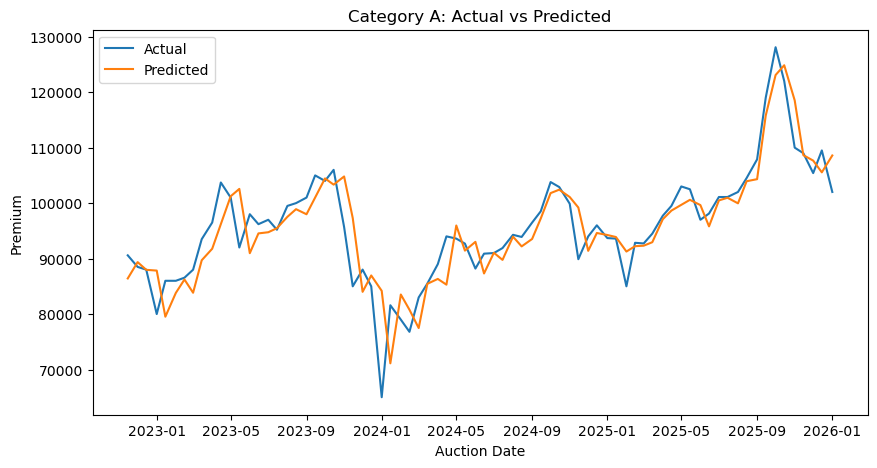

In [63]:
pred_df_A = make_pred_df(tmp_A, y_te, preds_A)

plot_predictions(pred_df_A, title="Category A: Actual vs Predicted")

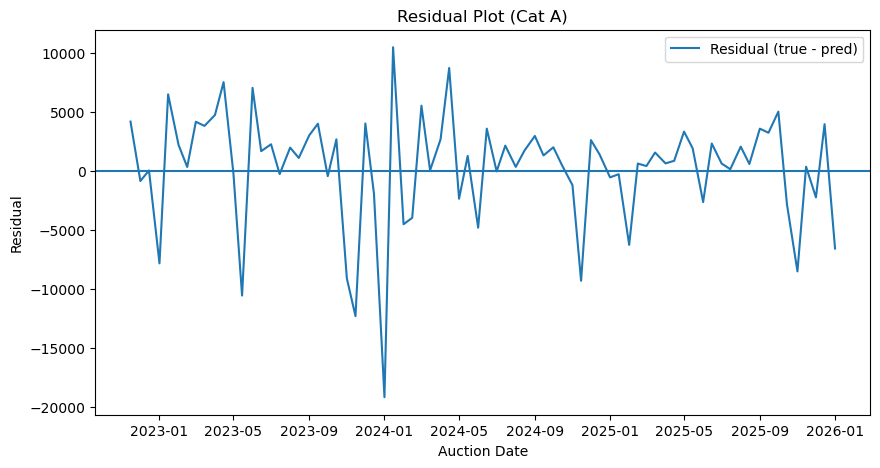

In [73]:
plot_residuals(pred_df_A, title="Residual Plot (Cat A)")

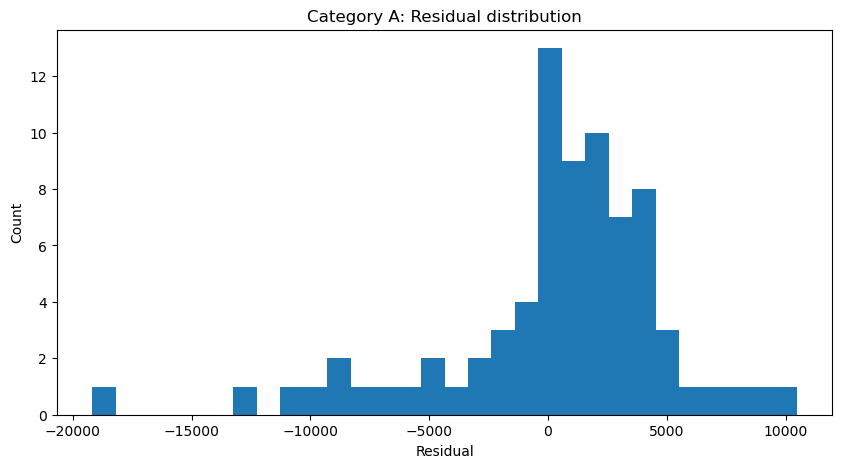

In [65]:
plot_residual_hist(pred_df_A, title="Category A: Residual distribution")


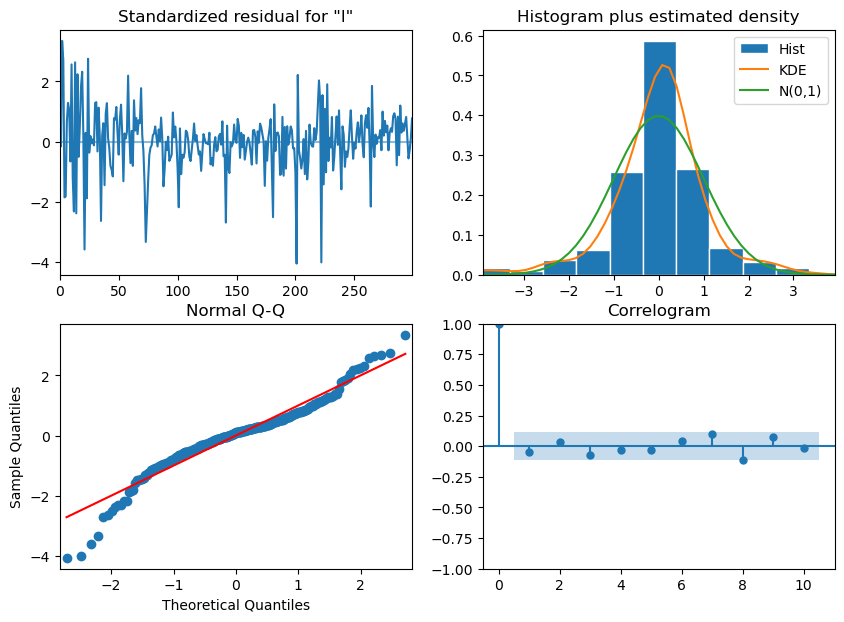

In [66]:
sarimax_diagnostics(res_A)

### Category B

In [78]:
tmp_B, y_B, X_B = prepare_category_data(price_df, "Category B")

y_tr, y_te, X_tr, X_te = train_test_split_time(y_B, X_B)

res_B = fit_sarimax(y_tr, X_tr, order=(1, 0, 2), seasonal_order=(0, 0, 0, 12))

metrics_B, preds_B = evaluate_model(res_B, y_te, X_te)

print(metrics_B)

{'RMSE': 7388.478553963874, 'MAE': 4604.567249724202, 'MAPE': 0.040583850036583755}


In [81]:
res_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_premium   No. Observations:                  302
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 374.235
Date:                Sun, 11 Jan 2026   AIC                           -728.471
Time:                        15:27:05   BIC                           -691.466
Sample:                             0   HQIC                          -713.660
                                - 302                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
log_quota            0.0049      0.009      0.531      0.596      -0.013       0.023
log_oversub          0.2369      0.024      9.735      0.000       0.189       0.285
log_premium_lag1     0.9917      0.006    160.362      0.000       0.980       1.004
log_oversub_lag1    -0.0795      0.030     -2.690      0.007      -0.137      -0.022
moy_sin             -0.0070      0.008     -0.877      0.381      -0.023       0.009
moy_cos              0.0043      0.008      0.535      0.593      -0.011       0.020
ar.L1               -0.1576      1.902     -0.083      0.934      -3.884       3.569
ma.L1                0.2171      1.902      0.114      0.909      -3.510       3.944
ma.L2                0.0186      0.117      0.158      0.874      -0.212       0.249
sigma2               0.0048      0.000     17.069      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8242.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
res_B.params

log_quota           0.004945
log_oversub         0.236914
log_premium_lag1    0.991738
log_oversub_lag1   -0.079459
moy_sin            -0.007000
moy_cos             0.004253
ar.L1              -0.157580
ma.L1               0.217139
ma.L2               0.018606
sigma2              0.004788
dtype: float64

### Performance Evaluation

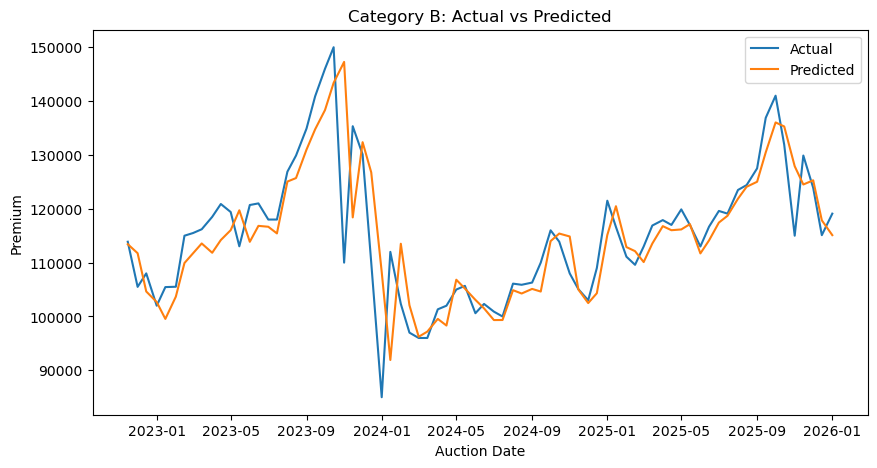

In [68]:
pred_df_B = make_pred_df(tmp_B, y_te, preds_B)

plot_predictions(pred_df_B, title="Category B: Actual vs Predicted")

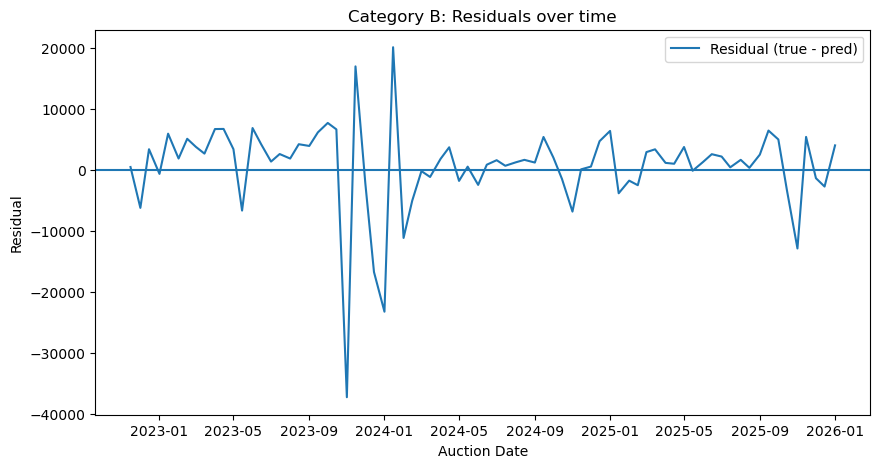

In [69]:
plot_residuals(pred_df_B, title="Category B: Residuals over time")

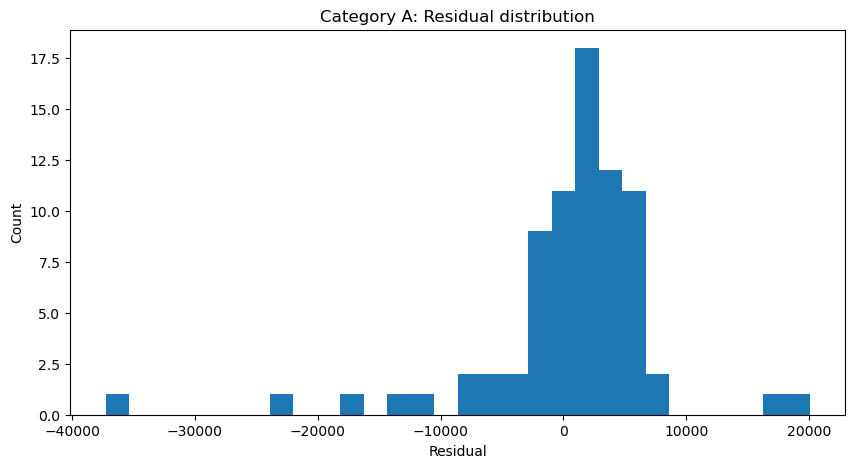

In [70]:
plot_residual_hist(pred_df_B, title="Category A: Residual distribution")

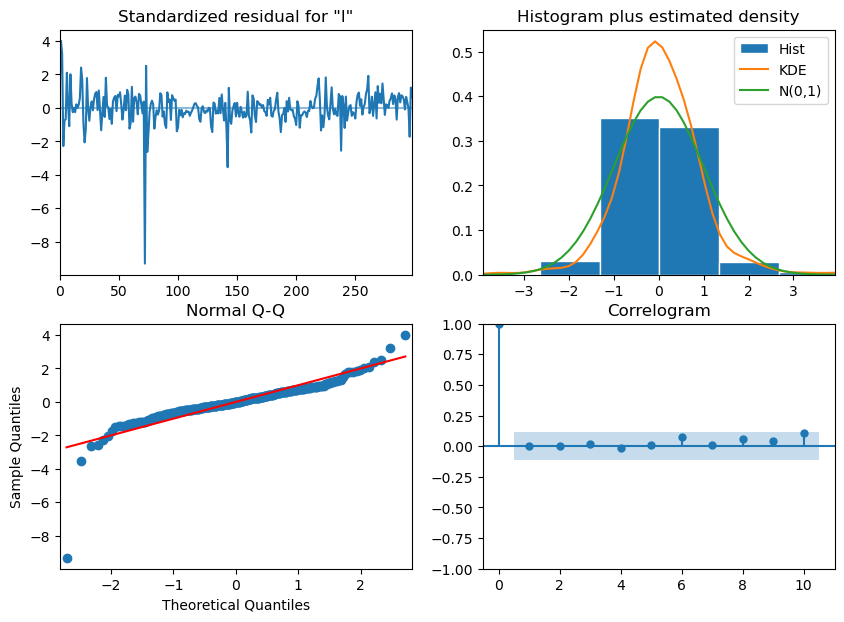

In [71]:
sarimax_diagnostics(res_B)

## Hyperparameter Tuning

In [38]:
def make_param_grid():
    orders = list(product([0,1,2], [0,1], [0,1,2]))          # (p,d,q)
    seasonal_orders = list(product([0,1], [0,1], [0,1], [12])) # (P,D,Q,12)
    return orders, seasonal_orders

def sarimax_cv_rmse(y, X, order, seasonal_order, n_splits=5):
    """
    Returns average RMSE across TimeSeriesSplit folds.
    y is log_premium, X is exog features aligned with y.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []

    for train_idx, val_idx in tscv.split(X):
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

        try:
            res = fit_sarimax(y_train, X_train, order=order, seasonal_order=seasonal_order)

            # Forecast validation length
            y_pred_log = res.get_forecast(steps=len(y_val), exog=X_val).predicted_mean

            # Back-transform
            y_pred = np.exp(y_pred_log)
            y_true = np.exp(y_val)

            rmse = root_mean_squared_error(y_true, y_pred)
            rmses.append(rmse)

        except Exception:
            # If model fails to converge / errors, treat as bad
            return np.inf

    return float(np.mean(rmses)) if rmses else np.inf

def tune_sarimax_grid(y, X, n_splits=5, max_evals=None):
    orders, seasonal_orders = make_param_grid()
    # print(orders, seasonal_orders)

    results = []
    eval_count = 0

    for order in orders:
        for seas in seasonal_orders:
            # print(order, seas)
            eval_count += 1
            if max_evals is not None and eval_count > max_evals:
                break

            score = sarimax_cv_rmse(y, X, order, seas, n_splits=n_splits)
            results.append({
                "order": order,
                "seasonal_order": seas,
                "cv_rmse": score
            })

        if max_evals is not None and eval_count > max_evals:
            break

    results_df = pd.DataFrame(results).sort_values("cv_rmse").reset_index(drop=True)
    best = results_df.iloc[0].to_dict()
    return best, results_df

In [52]:
# Prepare category A
tmp_A, y_A, X_A = prepare_category_data(price_df, "Category A")
y_tr, y_te, X_tr, X_te = train_test_split_time(y_A, X_A)

# Tune
best_A, table_A = tune_sarimax_grid(y_tr, X_tr, n_splits=5, max_evals=None)

best_A

{'order': (1, 0, 1),
 'seasonal_order': (0, 0, 0, 12),
 'cv_rmse': 3355.4112570113807}

In [53]:
def fit_best_and_test(y, X, test_frac=0.2, best_order=(1,0,1), best_seasonal=(1,0,1,12)):

    y_train, y_test, X_train, X_test = train_test_split_time(y, X, test_frac=test_frac)

    res = fit_sarimax(y_train, X_train, order=best_order, seasonal_order=best_seasonal)
    metrics, y_pred = evaluate_model(res, y_test, X_test)

    return res, metrics, y_pred, y_test

In [54]:
res_A_best, metrics_A_best, preds_A_best, y_te_A_best = fit_best_and_test(
    y_A, X_A,
    test_frac=0.2,
    best_order=best_A["order"],
    best_seasonal=best_A["seasonal_order"]
)

metrics_A_best

{'RMSE': 4806.406109902141, 'MAE': 3397.9137188796194}

In [55]:
# Prepare category B
tmp_B, y_B, X_B = prepare_category_data(price_df, "Category B")
y_tr, y_te, X_tr, X_te = train_test_split_time(y_B, X_B)

# Tune
best_B, table_B = tune_sarimax_grid(y_tr, X_tr, n_splits=5, max_evals=None)

best_B

{'order': (1, 0, 2),
 'seasonal_order': (0, 0, 0, 12),
 'cv_rmse': 5280.554529988576}

In [56]:
res_B_best, metrics_B_best, preds_B_best, y_te_B_best = fit_best_and_test(
    y_B, X_B,
    test_frac=0.2,
    best_order=best_B["order"],
    best_seasonal=best_B["seasonal_order"]
)

metrics_B_best

{'RMSE': 7388.478553963874, 'MAE': 4604.567249724202}